# Visualise trajectories for different models
This notebook can be used to visualise trajectories from the different models. It serves as a sanity check to verify that the models work as expected and to get a feeling for the shape of the trajectories.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import tensorflow as tf

from conservative_nn.dynamical_system import (
    XYModelSystem,
    RelativisticChargedParticleSystem, 
    DoubleWellPotentialSystem,
    TwoParticleSystem,
    SchwarzschildSystem
)
from conservative_nn.initializer import (
    XYModelRandomInitializer,
    RelativisticChargedParticleRandomInitializer,
    SingleParticleConstantInitializer,
    TwoParticleConstantInitializer,
    SchwarzschildConstantInitializer
)
from conservative_nn.time_integrator import RK4Integrator
from conservative_nn.monitors import (
    PositionMonitor,
    VelocitySumMonitor,
    
)
from conservative_nn.trajectory_generator import TrajectoryGenerator


%matplotlib inline
%load_ext autoreload
%autoreload 2

## XY Model system
Plot the positions $q_j$ of all particles and the sum of all velocities $\sum_{j=0}^{d-1}\dot{q}_j$. This sum should be constant since the Lagrangian is invariant under global rotations

$$
\mathcal{L}(\theta_0+\phi,\theta_1+\phi,\dots,\theta_{d-1}+\phi) = \mathcal{L}(\theta_0,\theta_1,\dots,\theta_{d-1})
$$

Text(0.5, 1.0, 'Sum of all velocities')

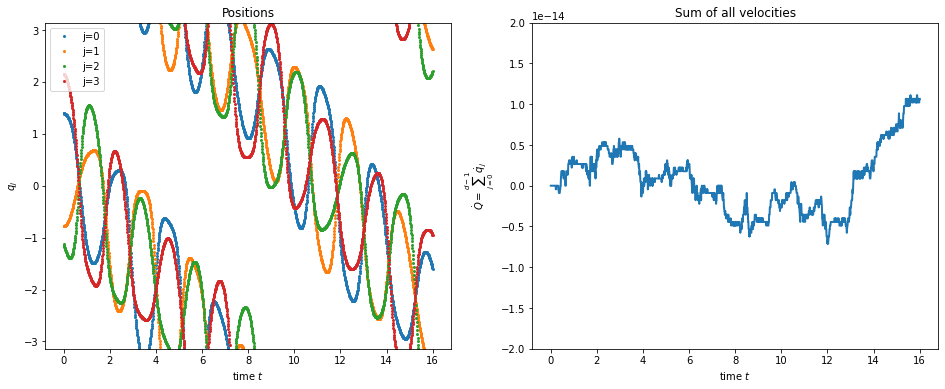

In [3]:
np.random.seed(2145127)
dim = 4
dynamical_system = XYModelSystem(dim)

monitors = [PositionMonitor(),VelocitySumMonitor()]
initializer = XYModelRandomInitializer(dim)

trajectory_generator1 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=16.0)
trajectory_generator1.run()

# Map to interval [-pi,+pi]
def map_to_interval(x):
    return x - 2.*np.pi*((x+np.pi)//(2.*np.pi))

q_all = np.vectorize(map_to_interval)(trajectory_generator1.monitors[0].data)
sum_qdot = trajectory_generator1.monitors[1].data

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plot position
for j in range(dim):
    ax1.plot(trajectory_generator1.t,q_all[j,:],linewidth=0,marker="o",markersize=2,label=f"j={j:d}")
ax1.set_xlabel("time $t$")
ax1.set_ylabel("$q_j$")
ax1.set_ylim(-np.pi,+np.pi)
ax1.legend(loc="upper left")
ax1.set_title("Positions")

# Plot sum of all velocities
ax2.set_ylim(-2.E-14,+2.E-14)
ax2.plot(trajectory_generator1.t,sum_qdot-sum_qdot[0],linewidth=2)
ax2.set_xlabel("time $t$")
ax2.set_ylabel(r"$\dot{Q} = \sum_{j=0}^{d-1}\dot{q}_j$")
ax2.set_title("Sum of all velocities")

## Charged particle in electrodynamic field
Plot the position of a charged relativistic particle moving in a combined magnetic and electric field, both of which are aligned with the vertical direction.

The magnetic field is assumed to be constant while the electric field $E_z = -z\hat{E}$ varies linearly in the vertical direction, thus trapping the particle.

Text(0.5, 0.92, 'Trajectories in 3d space')

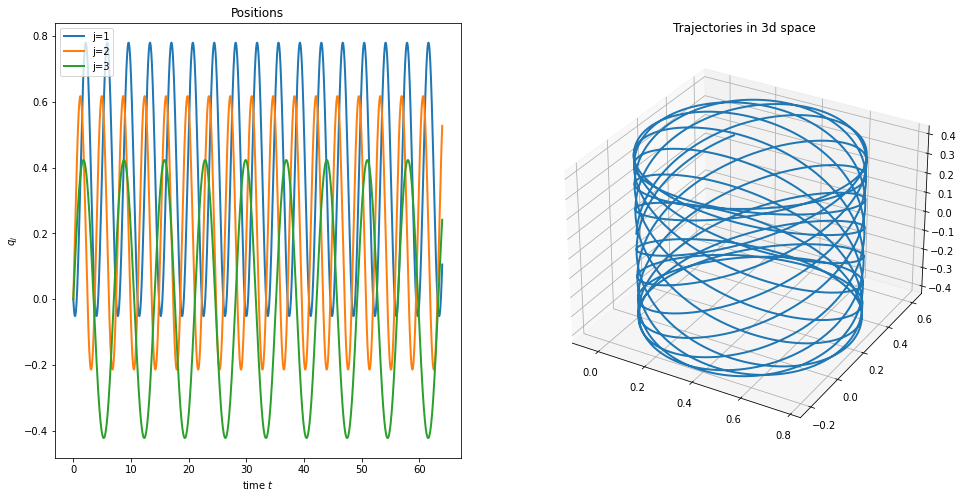

In [4]:
np.random.seed(2145127)
dim = 4
mass = 1.1
charge = 0.93
E_electric = [0, 0, 1.0]
B_magnetic = [0, 0, 2.0]
B = np.asarray(B_magnetic)

dynamical_system = RelativisticChargedParticleSystem(mass, charge, E_electric, B_magnetic, constant_E_electric=False)

monitors = [PositionMonitor()]
initializer = RelativisticChargedParticleRandomInitializer(rho=0.8)

trajectory_generator2 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=64.0)
trajectory_generator2.run()

# Visualise trajectories
q_all = trajectory_generator2.monitors[0].data

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)

# Plot position
for j in range(1,4):
    ax1.plot(trajectory_generator2.t,q_all[j,:],linewidth=2,label=f"j={j:d}")
ax1.set_xlabel("time $t$")
ax1.set_ylabel("$q_j$")
ax1.legend(loc="upper left")
ax1.set_title("Positions")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(q_all[1,:],q_all[2,:],zs=q_all[3,:],linewidth=2)
ax2.set_title("Trajectories in 3d space")

## Single particle moving in double well potential

Plot the position of a single $d$-dimensional particle moving in the double well potential

$$
V(q) = -\frac{\mu}{2}|q|^2+\frac{\kappa}{4}|q|^4\qquad\text{with $|x|=\sum_{\mu=0}^{d-1} q_\mu^2$}
$$

Both the positions $q_\mu(t)$ as a function of time and 2d-cross sections through the trajectories $q_\mu$ vs $q_\mu$ are visualised.

Loading random numbers from file /Users/eikemueller/Work/Bath/git_workspace/mlconservation_code/src/conservative_nn/random_normal_table.json


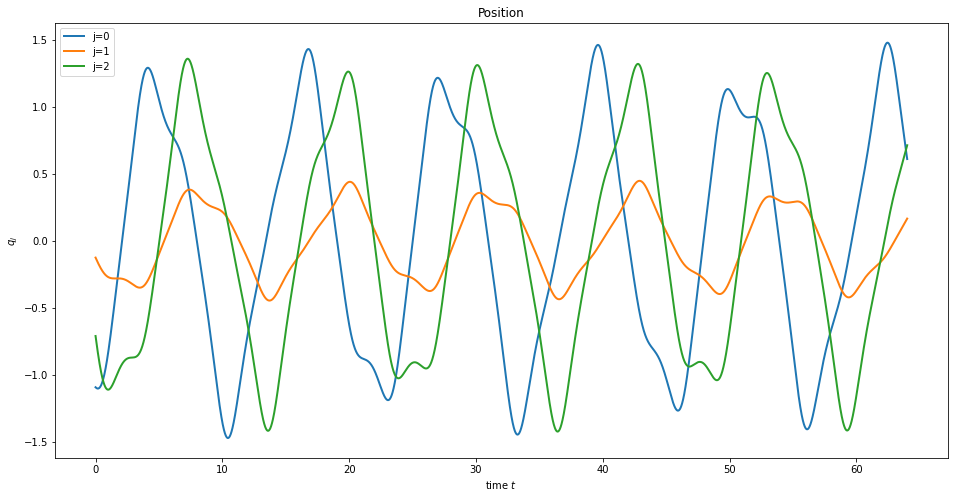

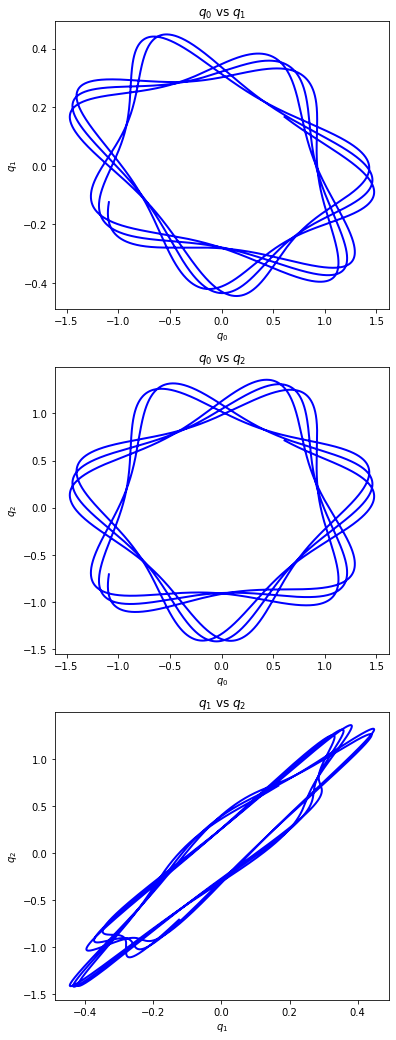

In [5]:
dim = 3
mass = 1.1
mu = 1.2
kappa = 0.97

dynamical_system = DoubleWellPotentialSystem(dim, mass,mu,kappa)
initializer = SingleParticleConstantInitializer(dim)
monitors = [PositionMonitor()]

trajectory_generator3 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=64.0)
trajectory_generator3.run()

q_all = trajectory_generator3.monitors[0].data

fig = plt.figure(figsize=(16,8))
ax = plt.gca()

for j in range(dim):
    ax.plot(trajectory_generator3.t,q_all[j,:],linewidth=2,label=f"j={j:d}")
ax.set_xlabel("time $t$")
ax.set_ylabel("$q_j$")
ax.legend(loc="upper left")
ax.set_title("Position")

nplots = len(list(combinations(range(dim), 2)))
fig, axs = plt.subplots(nplots,figsize=(6,6*nplots))

for ell, (j,k) in enumerate(combinations(range(dim), 2)):
    axs[ell].plot(q_all[j,:],q_all[k,:],linewidth=2,color="blue")
    axs[ell].set_xlabel(f"$q_{j}$")
    axs[ell].set_ylabel(f"$q_{k}$")
    axs[ell].set_title(f"$q_{j}$ vs $q_{k}$")

## System of two interacting particles
Motion of two $d$-dimensional particles moving under the influence of a double well potential.

Loading random numbers from file /Users/eikemueller/Work/Bath/git_workspace/mlconservation_code/src/conservative_nn/random_normal_table.json


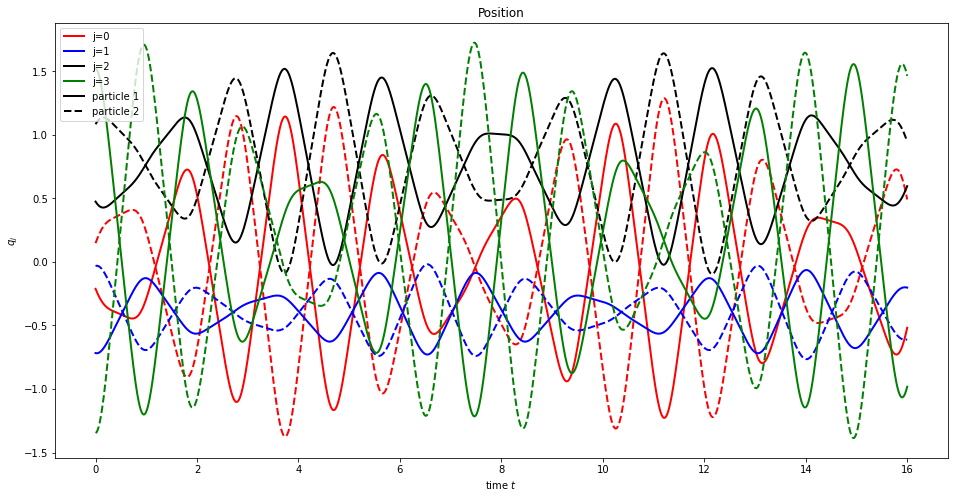

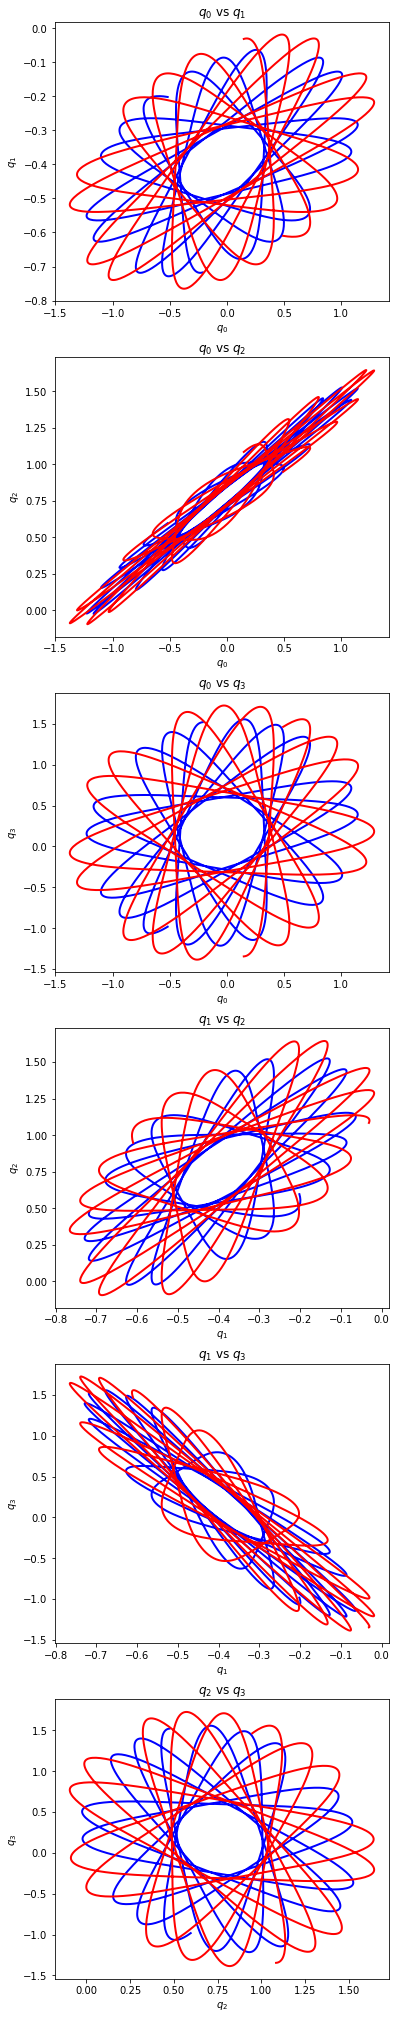

In [6]:
dim_space = 4
dim = 2*dim_space
mass1 = 1.1
mass2 = 0.98
mu = 1.2
kappa = 0.97

dynamical_system = TwoParticleSystem(dim_space, mass1,mass2,mu,kappa)
initializer = TwoParticleConstantInitializer(dim,mass1,mass2)
monitors = [PositionMonitor()]

trajectory_generator4 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=16.0)
trajectory_generator4.run()

q_all = trajectory_generator4.monitors[0].data

fig = plt.figure(figsize=(16,8))
ax = plt.gca()

colors=['red','blue','black','green','orange']
for j in range(dim_space):
    ax.plot(trajectory_generator4.t,q_all[j,:],linewidth=2,label=f"j={j:d}",color=colors[j])
    ax.plot(trajectory_generator4.t,q_all[dim_space+j,:],linewidth=2,linestyle='--',color=colors[j])
ax.plot([],[],linestyle='-',color="black",linewidth=2,label="particle 1")
ax.plot([],[],linestyle='--',color="black",linewidth=2,label="particle 2")
ax.set_xlabel("time $t$")
ax.set_ylabel("$q_j$")
ax.legend(loc="upper left")
ax.set_title("Position")

nplots = len(list(combinations(range(dim_space), 2)))
fig, axs = plt.subplots(nplots,figsize=(6,6*nplots))

for ell, (j,k) in enumerate(combinations(range(dim_space), 2)):
    axs[ell].plot(q_all[j,:],q_all[k,:],linewidth=2,color="blue",label="particle 1")
    axs[ell].plot(q_all[dim_space+j,:],q_all[dim_space+k,:],linewidth=2,color="red",label="particle 2")
    axs[ell].set_xlabel(f"$q_{j}$")
    axs[ell].set_ylabel(f"$q_{k}$")
    axs[ell].set_title(f"$q_{j}$ vs $q_{k}$")


## Relativistic particle in Schwarzschild metric

Loading random numbers from file /Users/eikemueller/Work/Bath/git_workspace/mlconservation_code/src/conservative_nn/random_normal_table.json


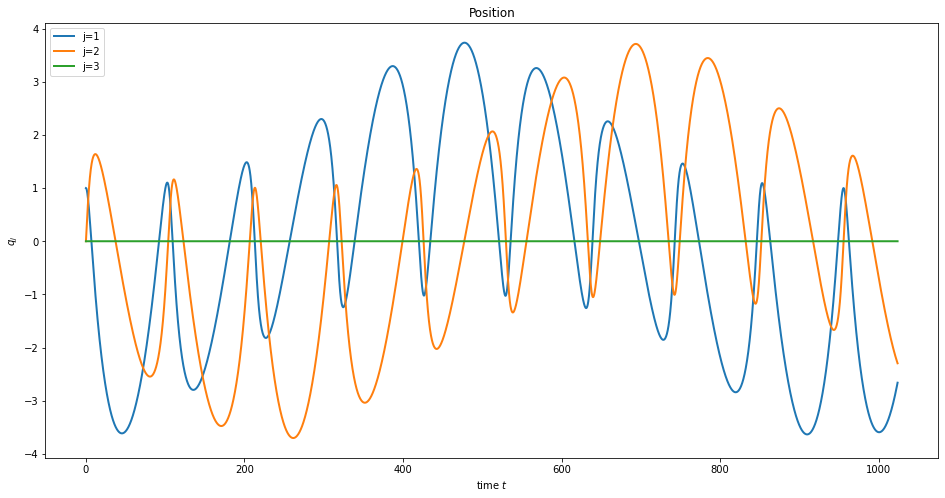

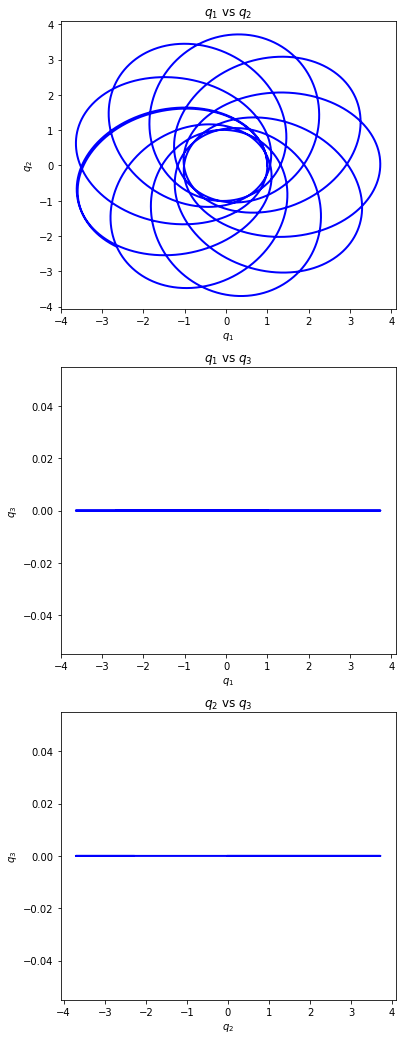

In [7]:
dim = 4
r_s = 0.1

dynamical_system = SchwarzschildSystem(r_s)

initializer = SchwarzschildConstantInitializer(r_s)
monitors = [PositionMonitor()]

trajectory_generator5 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.1,t_final=1024.0)
trajectory_generator5.run()

q_all = trajectory_generator5.monitors[0].data

fig = plt.figure(figsize=(16,8))
ax = plt.gca()

for j in range(1,dim):
    ax.plot(trajectory_generator5.t,q_all[j,:],linewidth=2,label=f"j={j:d}")
ax.set_xlabel("time $t$")
ax.set_ylabel("$q_j$")
ax.legend(loc="upper left")
ax.set_title("Position")

nplots = len(list(combinations(range(1,dim), 2)))
fig, axs = plt.subplots(nplots,figsize=(6,6*nplots))

for ell, (j,k) in enumerate(combinations(range(1,dim), 2)):
    axs[ell].plot(q_all[j,:],q_all[k,:],linewidth=2,color="blue")
    axs[ell].set_xlabel(f"$q_{j}$")
    axs[ell].set_ylabel(f"$q_{k}$")
    axs[ell].set_title(f"$q_{j}$ vs $q_{k}$")